# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [ ]:
# You can set them inline
import os
os.environ["GROQ_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [2]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
!pip install -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.3 MB/s eta 0:00:00


In [4]:
!pip install graphviz

In [5]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00


/content/utils.py:23: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Fetching pages: 100%|##########| 197/197 [00:48<00:00,  4.04it/s]


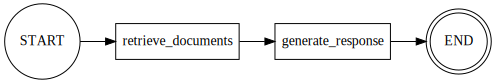

In [7]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_groq import ChatGroq # Changed from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT
from graphviz import Digraph

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0) # Changed model to Groq

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

dot = Digraph()
dot.attr(rankdir="LR")

dot.node("START", shape="circle")
dot.node("retrieve_documents", shape="box")
dot.node("generate_response", shape="box")
dot.node("END", shape="doublecircle")

dot.edge("START", "retrieve_documents")
dot.edge("retrieve_documents", "generate_response")
dot.edge("generate_response", "END")

display(dot)

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [8]:
simple_rag_graph = graph_builder.compile()

question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To enable tracing with LangChain, install\u202f`langsmith` and set the environment variable\u202f`LANGSMITH_TRACING=true` (or pass a\u202f`LangChainTracer`\u202finstance manually).\u202fOptionally set\u202f`LANGSMITH_PROJECT`\u202fto name the project where traces are stored.\u202fIn Python you can then wrap calls with\u202f`with ls.tracing_context(enabled=True): …`\u202for supply the tracer as a callback to trace specific runs.', additional_kwargs={'reasoning_content': 'We need to answer: "How do I set up tracing if I\'m using LangChain?" Use context. The context describes tracing with LangSmith, environment variables, tracing_context, passing LangChainTracer, setting LANGSMITH_PROJECT, etc. Provide concise answer, max three sentences. Probably: install langsmith, set LANGS

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [9]:
from langsmith import traceable, trace
from groq import Groq
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "groq"
MODEL_NAME = "openai/gpt-oss-120b"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

# ✅ Initialize Groq client (uses GROQ_API_KEY env var)
groq_client = Groq()

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_groq(messages)

@traceable
def call_groq(messages: List[dict]):
    """
    Wrapper for Groq chat completion
    """
    response = groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )
    return response

@traceable(run_type="chain")
def langsmith_rag_with_groq(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [10]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag_with_groq(question)
print(ai_answer)

Wrap the code you want traced in a `ls.tracing_context(enabled=True)` context manager. Inside that block, any LangChain runnable (e.g., `chain.invoke(...)`) will be logged to LangSmith; calls outside the block (or with `enabled=False`) won’t be traced. Make sure tracing is globally enabled (e.g., `LANGSMITH_TRACING=true`) or set a project via `LANGSMITH_PROJECT`.


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [11]:
from langsmith import traceable
from groq import Groq
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "groq"
MODEL_NAME = "openai/gpt-oss-120b"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

# ✅ Initialize Groq client (requires GROQ_API_KEY in environment)
groq_client = Groq()

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # ✅ No wrap_openai needed, we directly call Groq
    return call_groq(messages)

@traceable
def call_groq(messages: List[dict]):
    """
    Wrapper for Groq chat completion
    """
    response = groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )
    return response

@traceable(run_type="chain")
def langsmith_rag_with_groq(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [12]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_groq(question)
print(ai_answer)

To trace OpenAI calls, first set `LANGSMITH_TRACING=true` (and `LANGSMITH_API_KEY`/`LANGSMITH_WORKSPACE_ID` if needed), then wrap the OpenAI client with `wrap_openai` (e.g., `client = wrap_openai(OpenAI(...))`). After wrapping, any calls you make (e.g., `client.chat.completions.create(...)`) will automatically be logged to LangSmith. Optionally, you can add custom OpenTelemetry spans or attributes around the calls for richer metadata.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [13]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

groq_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
)

ChatCompletion(id='chatcmpl-8d3ce272-f96f-4eb3-bd1c-020bfd49bed4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sky is most often described as **blue** during a clear daylight hour, because molecules in Earth’s atmosphere scatter shorter‑wavelength (blue) light more effectively than other colors. \n\nAt different times and under different conditions the sky can take on other hues:\n\n- **Sunrise & sunset:** reds, oranges, pinks, and purples as the light passes through a longer path in the atmosphere, scattering out the blue and letting longer wavelengths dominate.  \n- **Overcast or rainy days:** shades of gray or white when clouds block direct sunlight.  \n- **Stormy or twilight conditions:** deep indigo or even black as the sun dips below the horizon.  \n- **Night:** the sky appears dark (black or deep navy) with stars, planets, and the Moon visible, and can acquire a faint orange‑pink glow near the horizon from city light p

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [ ]:
import os
os.environ["GROQ_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [15]:
from langsmith import RunTree
from groq import Groq   # ✅ use Groq client
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

# ✅ Initialize Groq client (uses GROQ_API_KEY from env)
groq_client = Groq()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the latest question in the conversation.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    groq_response = call_groq(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"groq_response": groq_response})
    child_run.post()
    return groq_response

def call_groq(
    parent_run: RunTree, messages: List[dict], model: str = "openai/gpt-oss-120b", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="Groq Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    groq_response = groq_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"groq_response": groq_response})
    child_run.post()
    return groq_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

In [16]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

You can create a RunTree from the RunnableConfig by calling `RunTree.fromRunnableConfig(config)`. Then use that RunTree when invoking a traceable function (or simply pass the RunnableConfig as the first argument to a traceable‑wrapped function). This lets the LangChain run be recorded in LangSmith’s trace UI.


# **MY EXAMPLES**

In [26]:
from langsmith import RunTree

def calculator_tool(a: int, b: int):
    return a + b

def math_pipeline():
    root = RunTree(name="Math Pipeline", run_type="chain", inputs={"task": "add numbers"})

    tool = root.create_child("Calculator", "tool", inputs={"a": 5, "b": 7})
    result = calculator_tool(5, 7)
    tool.end(outputs={"result": result}); tool.post()

    llm = root.create_child("LLM Explain", "llm", inputs={"calc_result": result})
    explanation = f"The result of addition is {result}."
    llm.end(outputs={"answer": explanation}); llm.post()

    root.end(outputs={"final": explanation}); root.post()
    return explanation

print(math_pipeline())

The result of addition is 12.
